In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.svm import LinearSVC

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
df_original = pd.read_csv('train_40k.csv')
df_original.head()

,productId,Title,userId,Helpfulness,Score,Time,Text,Cat1,Cat2,Cat3
0,B000E46LYG,Golden Valley Natural Buffalo Jerky,A3MQDNGHDJU4MK,0/0,3.0,-1,The description and photo on this product need...,grocery gourmet food,meat poultry,jerky
1,B000GRA6N8,Westing Game,unknown,0/0,5.0,860630400,This was a great book!!!! It is well thought t...,toys games,games,unknown
2,B000GRA6N8,Westing Game,unknown,0/0,5.0,883008000,"I am a first year teacher, teaching 5th grade....",toys games,games,unknown
3,B000GRA6N8,Westing Game,unknown,0/0,5.0,897696000,I got the book at my bookfair at school lookin...,toys games,games,unknown
4,B00000DMDQ,I SPY A is For Jigsaw Puzzle 63pc,unknown,2/4,5.0,911865600,Hi! I'm Martine Redman and I created this puzz...,toys games,puzzles,jigsaw puzzles


In [3]:
# the only columns I care about are these two, as I'll be using the 'Text' column to predict the feature 'Cat1'

columns = ['Text', 'Cat1']

df = shuffle(df_original[columns])

In [4]:
df.Cat1.value_counts()

toys games              10266
health personal care     9772
beauty                   5846
baby products            5637
pet supplies             4862
grocery gourmet food     3617
Name: Cat1, dtype: int64

In [5]:
# data needs cleaning
df

,Text,Cat1
35387,I've used this many times and each time it's b...,grocery gourmet food
2399,I bought this toy for my two-year-old son. He ...,toys games
29797,If you like essential oils you'll appreciate t...,beauty
16354,Super fun for Tinkerbell lovers!! There are 2 ...,toys games
30146,"We have the frog version for our daughter, and...",toys games
...,...,...
30409,I've been using this pillow for several months...,baby products
362,I have played this game since high school and ...,toys games
32253,I wasnt sure what color of the numbers i am......,beauty
41,"We bought this game 4 or 5 years ago, and were...",toys games


In [6]:
#remove special characters from df using regular expressions

import re
p = re.compile(r'[^\w\s]+')

df['Text'] = [p.sub('', x) for x in df['Text'].tolist()]


In [7]:
# make all characters .lower()

df.apply(lambda x: x.astype(str).str.lower())

,Text,Cat1
35387,ive used this many times and each time its bee...,grocery gourmet food
2399,i bought this toy for my twoyearold son he sha...,toys games
29797,if you like essential oils youll appreciate th...,beauty
16354,super fun for tinkerbell lovers there are 2 ti...,toys games
30146,we have the frog version for our daughter and ...,toys games
...,...,...
30409,ive been using this pillow for several months ...,baby products
362,i have played this game since high school and ...,toys games
32253,i wasnt sure what color of the numbers i am so...,beauty
41,we bought this game 4 or 5 years ago and were ...,toys games


In [12]:
# train test split
x,y = df.Text, df.Cat1
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)
print(train_x.shape, train_x.head())
print(train_y.shape, train_y.head())

(32000,) 4720     This is the worst diaper pail ever with my dau...
10284    I had an eye pillow made by a different manufa...
35646    I love this cream  its great for the price non...
29112    This item was not offered with a size chart it...
8444     I have been using the nailtiques products sinc...
Name: Text, dtype: object
(32000,) 4720            baby products
10284    health personal care
35646                  beauty
29112    health personal care
8444                   beauty
Name: Cat1, dtype: object


In [10]:
# build a pipeline 

pipeline = Pipeline([('vect', TfidfVectorizer(ngram_range=(1,2), stop_words='english', sublinear_tf=True)),
                     ('chi', SelectKBest(chi2, k=10000)),
                     ('clf', LinearSVC(C=1.0, penalty='l1',max_iter=3000, dual=False))
                    ])


In [11]:
# fit pipline to our training data

model = pipeline.fit(train_x, train_y)

In [12]:
# check accuracy

print('accuracy score: '+ str(model.score(test_x, test_y)))

accuracy score: 0.8505


In [15]:
print(model.predict(['bone lasted forever, will buy again']))

['pet supplies']


In [16]:
print(model.predict(['nice lipstick']))

['beauty']


In [15]:
print(model.predict(['creame was comfirtable with bone']))

['pet supplies']


                      precision    recall  f1-score   support

       baby products       0.89      0.85      0.87      5637
              beauty       0.88      0.85      0.87      5846
grocery gourmet food       0.91      0.86      0.88      3617
health personal care       0.81      0.88      0.84      9772
        pet supplies       0.94      0.88      0.91      4862
          toys games       0.92      0.93      0.92     10266

            accuracy                           0.88     40000
           macro avg       0.89      0.87      0.88     40000
        weighted avg       0.88      0.88      0.88     40000



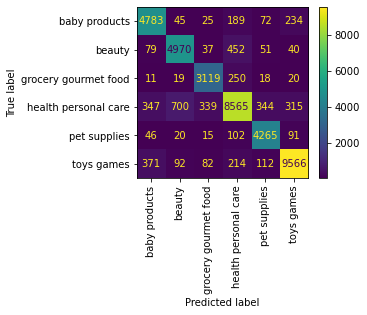

In [36]:
from sklearn.metrics import classification_report, plot_confusion_matrix
import matplotlib.pyplot as plt
y_pred = model.predict(x)
print(classification_report(y, y_pred))
plot_confusion_matrix(model,y, y_pred)
plt.xticks(rotation=90)
plt.show()